In [1]:
import os
os.chdir("..\..")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from fix_data import add_label_T
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
hcc_smarts_df_train = pd.read_csv("data/DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt", sep = " ")
mcf_smarts_df_train = pd.read_csv("data/DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt", sep= " ")

hcc_smarts_df_train = add_label_T(hcc_smarts_df_train)
mcf_smarts_df_train = add_label_T(mcf_smarts_df_train)

X1 = hcc_smarts_df_train.loc[:,hcc_smarts_df_train.columns!='label']
X2 = mcf_smarts_df_train.loc[:,mcf_smarts_df_train.columns!='label']
y = hcc_smarts_df_train["label"]

# Non linear svm

In [4]:
nlsvm = SVC()
cross = cross_val_score(nlsvm, X1, y, scoring="accuracy", cv=10)
print(f"Final accuracy = {round((sum(cross) / 10) * 100, 4)}%")
print(cross)

Final accuracy = 95.8928%
[0.97345133 0.96528251 0.94414169 0.95708447 0.94618529 0.95027248
 0.95640327 0.95980926 0.96253406 0.97411444]


In [6]:
x_train, x_test, y_train, y_test = train_test_split(X1, y, test_size=0.5)

In [7]:
svm = SVC()
p_grid = {'kernel': ['poly', 'rbf', 'sigmoid'],
          "C": [0.001, 0.1 , 1, 10, 100],
            }

gsin = GridSearchCV(svm, param_grid = p_grid, cv=2, scoring= 'accuracy', verbose= True ).fit(x_train, y_train)
gsin.best_params_

Fitting 2 folds for each of 15 candidates, totalling 30 fits


{'C': 10, 'kernel': 'rbf'}

In [8]:
svm_res_n = pd.DataFrame(gsin.cv_results_)[["param_C", "param_kernel", "mean_test_score", "rank_test_score"]]
svm_res_n.sort_values(by="mean_test_score", ascending=False, inplace=True)
svm_res_n.reset_index(drop= True, inplace=True)
svm_res_n.iloc[:20,:]

,param_C,param_kernel,mean_test_score,rank_test_score
0,10,rbf,0.950824,1
1,100,rbf,0.950824,1
2,1,rbf,0.947964,3
3,10,poly,0.942242,4
4,100,poly,0.940199,5
5,0.1,rbf,0.909822,6
6,1,poly,0.898652,7
7,0.1,sigmoid,0.876583,8
8,1,sigmoid,0.815013,9
9,10,sigmoid,0.786270,10


In [9]:
best_fit = {}
for i in [0.001, 0.1 , 1, 10, 100]:
    best_fit[f"{i}"] = max([svm_res_n.iloc[j,:].values for j in range(svm_res_n.shape[0]) if svm_res_n.iloc[j,0] == i], key= lambda x: x[2])[2]

best_fit

{'0.001': 0.6113608242525368,
 '0.1': 0.9098218454237017,
 '1': 0.9479636773087837,
 '10': 0.9508244900564629,
 '100': 0.9508244900564629}

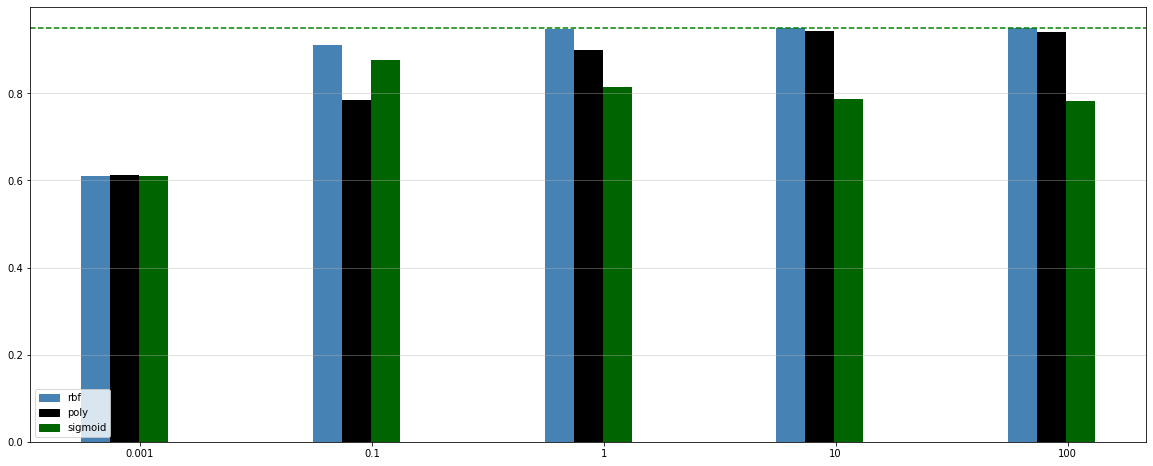

In [10]:
svm_res_n.sort_values(by="param_C", ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(20,8))

best = max(best_fit.values())

ax.bar([i for i in range(0,10,2)], [i for k,i in  enumerate(svm_res_n.loc[:,"mean_test_score"]) if svm_res_n.iloc[k, 1] == "rbf"], width= 0.25, color= "steelblue")
ax.bar([i + 0.25 for i in range(0,10,2)], [i for k,i in  enumerate(svm_res_n.loc[:,"mean_test_score"]) if svm_res_n.iloc[k, 1] == "poly"], width= 0.25, color= "black")
ax.bar([i + 0.25 + 0.25 for i in range(0,10,2)], [i for k,i in  enumerate(svm_res_n.loc[:,"mean_test_score"]) if svm_res_n.iloc[k, 1] == "sigmoid"], width= 0.25, color= "darkgreen")
ax.axhline(y=best, color='green', linestyle='--')

ax.set_xticks([i + 0.385 for i in range(0,10,2)], [0.001, 0.1 , 1, 10, 100])

ax.grid(axis= 'y', which= 'major', alpha=0.5)

colors = {"rbf": "steelblue", "poly": "black", "sigmoid": "darkgreen"}
label = list(colors.keys())
handle = [plt.Rectangle((0,0),2,2, color=colors[lab]) for lab in label]

ax.legend(handles= handle, labels= label, loc = "lower left")
plt.show() 

In [11]:
svm = SVC()
p_grid = {'kernel': ['poly'],
          "C": [1, 10, 100],
          "degree": [2, 4, 5]
            }

gsin = GridSearchCV(svm, param_grid = p_grid, cv=2, scoring= 'accuracy', verbose= True ).fit(x_train, y_train)
gsin.best_params_

Fitting 2 folds for each of 9 candidates, totalling 18 fits


{'C': 100, 'degree': 2, 'kernel': 'poly'}

In [12]:
svm_res_np = pd.DataFrame(gsin.cv_results_)[["param_C", "param_degree", "mean_test_score", "rank_test_score"]]
svm_res_np.sort_values(by="mean_test_score", ascending=False, inplace=True)
svm_res_np.reset_index(drop= True, inplace=True)
svm_res_np.iloc[:20,:]

,param_C,param_degree,mean_test_score,rank_test_score
0,100,2,0.947146,1
1,10,2,0.946738,2
2,1,2,0.940199,3
3,10,4,0.921129,4
4,100,4,0.916904,5
5,10,5,0.877811,6
6,100,5,0.874127,7
7,1,4,0.842392,8
8,1,5,0.795532,9


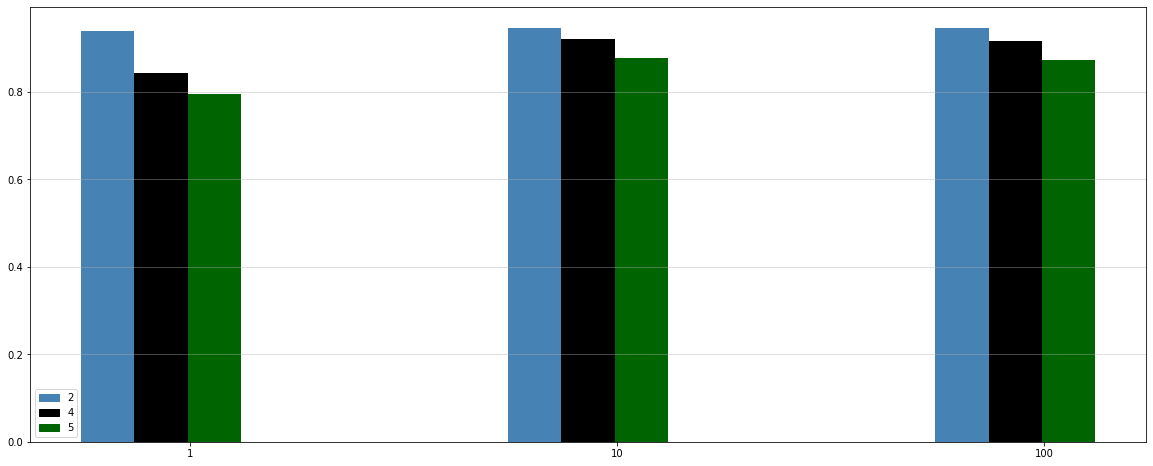

In [13]:
svm_res_np.sort_values(by="param_C", ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(20,8))

# best = max(best_fit.values())

ax.bar([i for i in range(0,6,2)], [i for k,i in  enumerate(svm_res_np.loc[:,"mean_test_score"]) if svm_res_np.iloc[k, 1] == 2], width= 0.25, color= "steelblue")
ax.bar([i + 0.25 for i in range(0,6,2)], [i for k,i in  enumerate(svm_res_np.loc[:,"mean_test_score"]) if svm_res_np.iloc[k, 1] == 4], width= 0.25, color= "black")
ax.bar([i + 0.25 + 0.25 for i in range(0,6,2)], [i for k,i in  enumerate(svm_res_np.loc[:,"mean_test_score"]) if svm_res_np.iloc[k, 1] == 5], width= 0.25, color= "darkgreen")
# ax.axhline(y=best, color='green', linestyle='--')

ax.set_xticks([i + 0.385 for i in range(0,6,2)], [1, 10, 100])

ax.grid(axis= 'y', which= 'major', alpha=0.5)

colors = {"2": "steelblue", "4": "black", "5": "darkgreen"}
label = list(colors.keys())
handle = [plt.Rectangle((0,0),2,2, color=colors[lab]) for lab in label]

ax.legend(handles= handle, labels= label, loc = "lower left")
plt.show() 

In [14]:
best_fit_d = {}
for i in [1, 10, 100]:
    best_fit_d[f"{i}"] = max([svm_res_np.iloc[j,:].values for j in range(svm_res_np.shape[0]) if svm_res_np.iloc[j,0] == i], key= lambda x: x[2])[2]

best_fit_d

{'1': 0.9401987890951764, '10': 0.9467375563830807, '100': 0.9471462386166856}

In [15]:
best_fit = [0.9479636773087837, 0.9508244900564629, 0.9508244900564629]

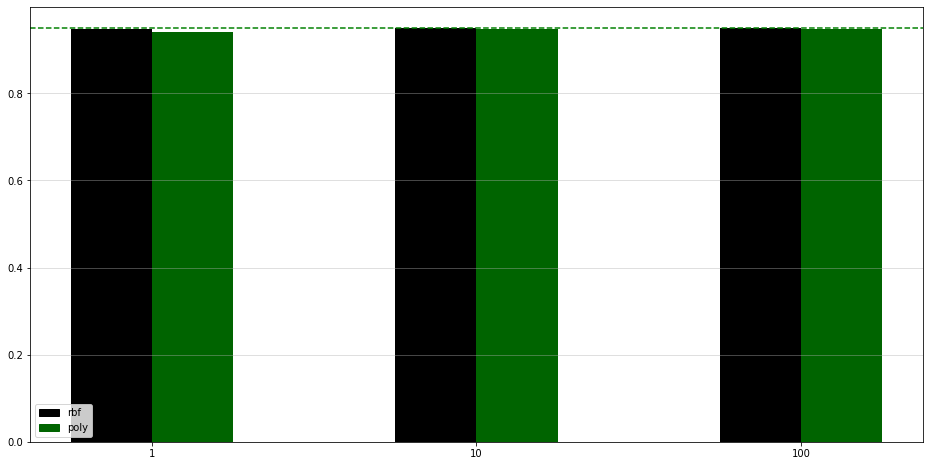

In [16]:
fig, ax = plt.subplots(figsize=(16,8))

ax.bar([i for i in range(3)], best_fit, 0.25, color = "black")
ax.bar([i + 0.25 for i in range(3)], list(best_fit_d.values()), 0.25, color = "darkgreen")

best = max([*[i for i in best_fit], *[i for i in best_fit_d.values()]])

ax.set_xticks([i + 0.125 for i in range(3)], [1, 10, 100])
ax.grid(axis= 'y', which= 'major', alpha=0.5)
ax.axhline(y=best, color='green', linestyle='--')

colors = {"rbf": "black", "poly": "darkgreen"}
label = list(colors.keys())
handle = [plt.Rectangle((0,0),2,2, color=colors[lab]) for lab in label]

ax.legend(handles= handle, labels= label, loc = "lower left")
plt.show() 

In [17]:
svm = SVC()
p_grid = {'kernel': ['poly', 'rbf'],
          "degree": [2],
          "C": [1, 10, 100],
          "gamma": ["scale", "auto"]
            }

gsin = GridSearchCV(svm, param_grid = p_grid, cv=2, scoring= 'accuracy', verbose= True ).fit(x_train, y_train)
gsin.best_params_

Fitting 2 folds for each of 12 candidates, totalling 24 fits


{'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

In [18]:
svm_res_npg = pd.DataFrame(gsin.cv_results_)[["param_kernel", "param_C", "param_gamma", "mean_test_score", "rank_test_score"]]
svm_res_npg.sort_values(by="mean_test_score", ascending=False, inplace=True)
svm_res_npg.reset_index(drop= True, inplace=True)
svm_res_npg.iloc[:20,:]

,param_kernel,param_C,param_gamma,mean_test_score,rank_test_score
0,rbf,10,scale,0.950824,1
1,rbf,100,scale,0.950824,1
2,rbf,10,auto,0.950415,3
3,rbf,1,scale,0.947964,4
4,rbf,100,auto,0.947964,4
5,poly,100,scale,0.947146,6
6,poly,10,scale,0.946738,7
7,poly,1,scale,0.940199,8
8,poly,100,auto,0.931753,9
9,rbf,1,auto,0.924125,10


In [27]:
svm = SVC()
p_grid = {'kernel': ['rbf'],
          "C": [55000,60000, 45000, 52500, 47500],
          "gamma": [0.0000001]
            }

gsin = GridSearchCV(svm, param_grid = p_grid, cv=2, scoring= 'accuracy', verbose= True ).fit(x_train, y_train)
gsin.best_params_

Fitting 2 folds for each of 5 candidates, totalling 10 fits


{'C': 52500, 'gamma': 1e-07, 'kernel': 'rbf'}

In [28]:
svm_res_npg = pd.DataFrame(gsin.cv_results_)[["param_kernel", "param_C", "param_gamma", "mean_test_score", "rank_test_score"]]
svm_res_npg.sort_values(by="mean_test_score", ascending=False, inplace=True)
svm_res_npg.reset_index(drop= True, inplace=True)
svm_res_npg.iloc[:,:]

,param_kernel,param_C,param_gamma,mean_test_score,rank_test_score
0,rbf,52500,0.0,0.947691,1
1,rbf,55000,0.0,0.947010,2
2,rbf,45000,0.0,0.946874,3
3,rbf,47500,0.0,0.946737,4
4,rbf,60000,0.0,0.945920,5
